### Problem Statement
Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

dataset https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/



In [23]:
import pandas as pd          
import numpy as np               # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
%matplotlib inline
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
train=pd.read_csv("Train_SU63ISt.csv")
train.head(5)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [3]:
test=pd.read_csv("Test_0qrQsBZ.csv")
test.head(5)

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [4]:
# keeping orignal dataset for reference
train_original=train.copy()
test_original=test.copy()

In [7]:
train.info()
train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
ID          18288 non-null int64
Datetime    18288 non-null object
Count       18288 non-null int64
dtypes: int64(2), object(1)
memory usage: 428.7+ KB


(18288, 3)

In [8]:
test.info()
test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
ID          5112 non-null int64
Datetime    5112 non-null object
dtypes: int64(1), object(1)
memory usage: 80.0+ KB


(5112, 2)

### Hypothesis setting 
The trend can be assumed to be affected by few of the factors, so in here will define some of the hypothesis before proceeding to the time series analysis.

* Traffic will increase as the years pass by
* Traffic will be high from May to October
* Traffic on weekdays will be more
* Traffic during the peak hours will be high

### Feature Extraction  
Considering the count as target variable which left us two variables `ID` and `DATETIME`, `ID` is unique identifier whihc is not useful for the analysis, `DATETIME` is the only attribute which has some important details. Hence purpose of this section is to get out significant informations from date.

In [9]:
# change the datatype 
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [10]:
# Obtaining year, month, day and time from datetime
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [12]:
# Extract weekdays and weekends
train['day of week']=train['Datetime'].dt.dayofweek
temp = train['Datetime']

assigning 1 if the day of week is a weekend and 0 if the day of week in not a weekend and convert to a binomial categorical variable. 



In [15]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

temp2 = train['Datetime'].apply(applyer)
train['weekend']=temp2

Plotting the timeseries 

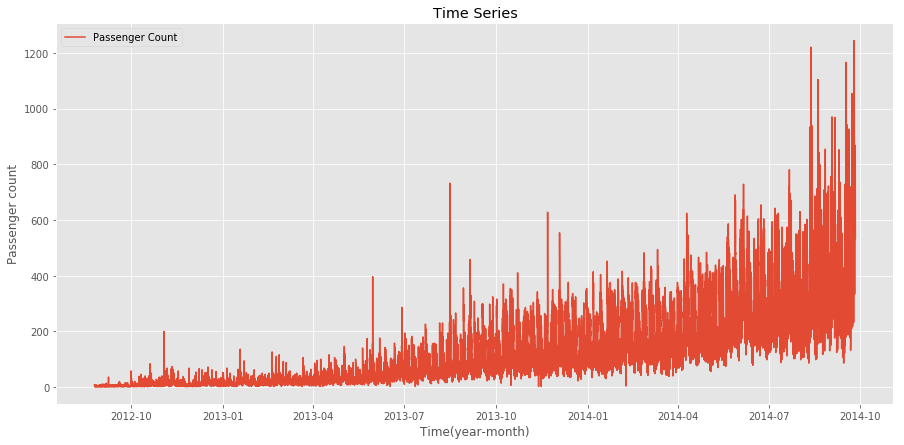

In [25]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis.
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis.
ts = df['Count']
plt.figure(figsize=(15,7))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

From above there is clearly a upward trend in the number of passengers over the time. The number of passanger is increasing with the time. There are few days where the traffic can be seen higher, i.e. lines with highest peak than its neighbours. The cause may be some function or event due to which count is high.  

### Exploratory analysis
visulise the given data and check if set hypothesis are valid or not? The first hypothesis was 

* Traffic will increase as the years pass by

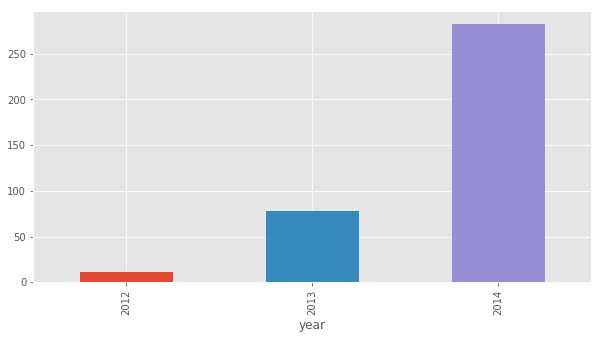

In [72]:
train.groupby('year')['Count'].mean().plot(kind = 'bar',figsize=(10,5))

Hypothesis 1, growth in traffic as year passes by seems to be correct. Same can be observed from above bar plot the count almost trippled. 

Hypothesis 2
* Traffic will be high from May to October

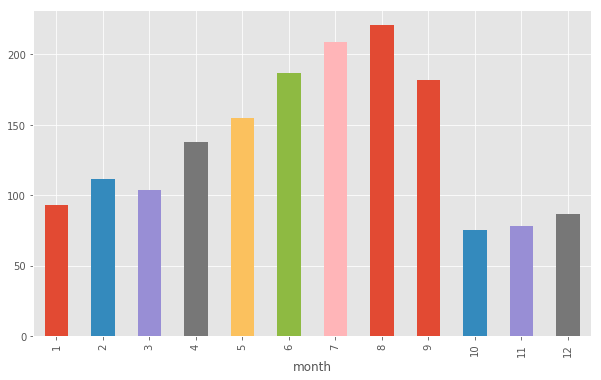

In [70]:
train.groupby('month')['Count'].mean().plot(kind = 'bar',figsize=(10,6))

mean trend per month seems to be increasing till september but there is drop trend for oct, nov and dec. This could be because of less passengers travelling on these months or it may be because of missing data or some other factors, this could be analysed by digging into further in by plotting mean count based on both year and month to see the yearly monthly effects. 

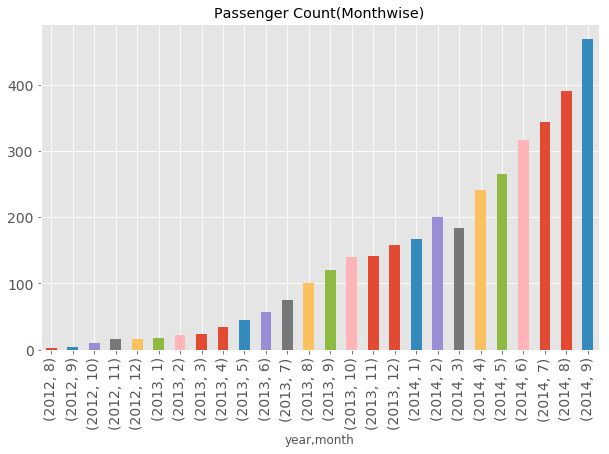

In [69]:
mask=train.groupby(['year', 'month'])['Count'].mean()
mask.plot(kind = 'bar',figsize=(10,6), title= 'Passenger Count(Monthwise)', fontsize=14)

Upon plotting yearly average of count per month since, the october, november and december months are missing from 2014 data causing the low average in passenger for last three months. However, the trends seems to be growing anyways which is evident from above plot. So, hypothesis 2 is also seems to be correct. 

Hypothesis 3
* Traffic on weekdays will be more

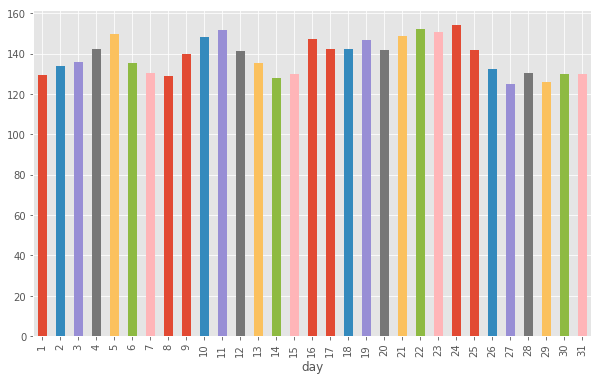

In [68]:
train.groupby('day')['Count'].mean().plot(kind = 'bar',figsize=(10,6))

Hypothesis 3 can not be clearly said to be correct as there is not much information from above graph.
Hypothesis 4
* Traffic during the peak hours will be high

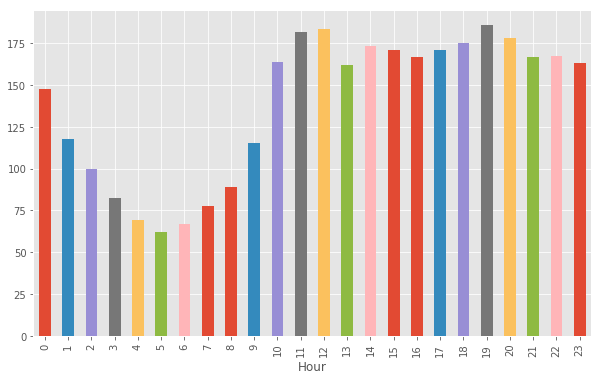

In [67]:
train.groupby('Hour')['Count'].mean().plot(kind = 'bar',figsize=(10,6))

peek hour can be said to be at 19:00 (7 PM) and morning 11:00 AM to 12:00 PM. There is comparatevily less traffic during nigth 12 AM to morning 9:00 AM. To get the insight based on weekdays and weekends. below is the plot

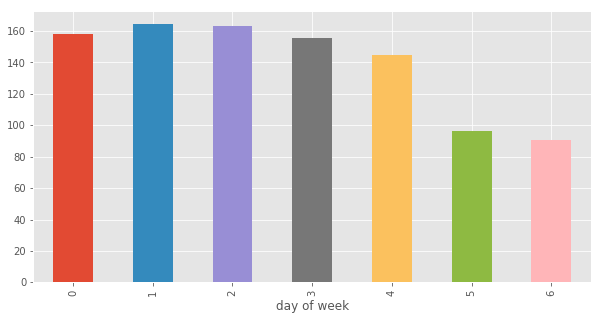

In [66]:
train.groupby('day of week')['Count'].mean().plot(kind = 'bar',figsize=(10,5))

On weekends the traffic is clearly less as there are no offices, schools and other weekdays activities. 

In [58]:
train=train.drop('ID',1)

In [60]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Hourly time series
hourly = train.resample('H').mean()

# Converting to daily mean
daily = train.resample('D').mean()

# Converting to weekly mean
weekly = train.resample('W').mean()

# Converting to monthly mean
monthly = train.resample('M').mean()

In [78]:
train.head()

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


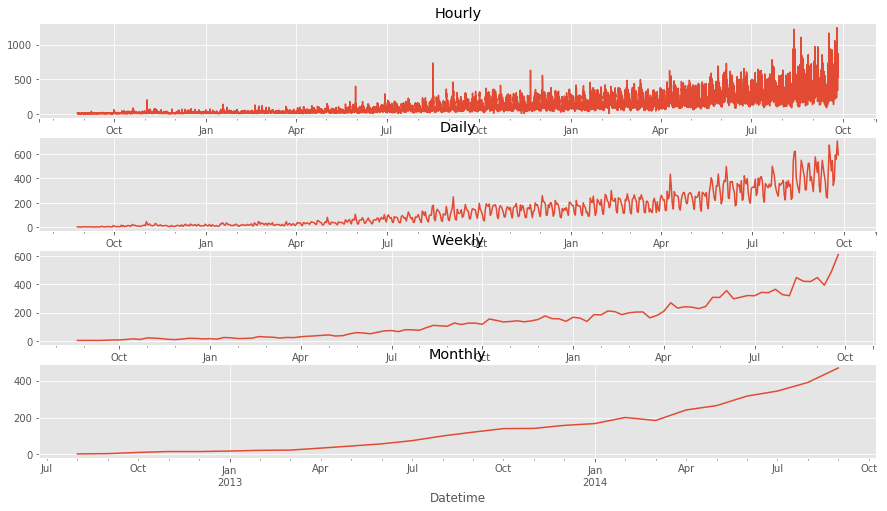

In [64]:
fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=10, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=10, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=10, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=10, ax=axs[3])

plt.show()

In [73]:
# Working on daily time series
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 

# Converting to daily mean
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

### Splitting the data into training and validation set
To divide data to training and validation, 3 months are considered as validation set rest is considered to be train set. Since this is time series hence, not any random 3 months but the last 3 months will be validation set. 
Dataset is from 2012-08-25 to 2014-09-25

In [79]:
train_set=train.ix['2012-08-25':'2014-06-24']
valid_set=train.ix['2014-06-25':'2014-09-25']

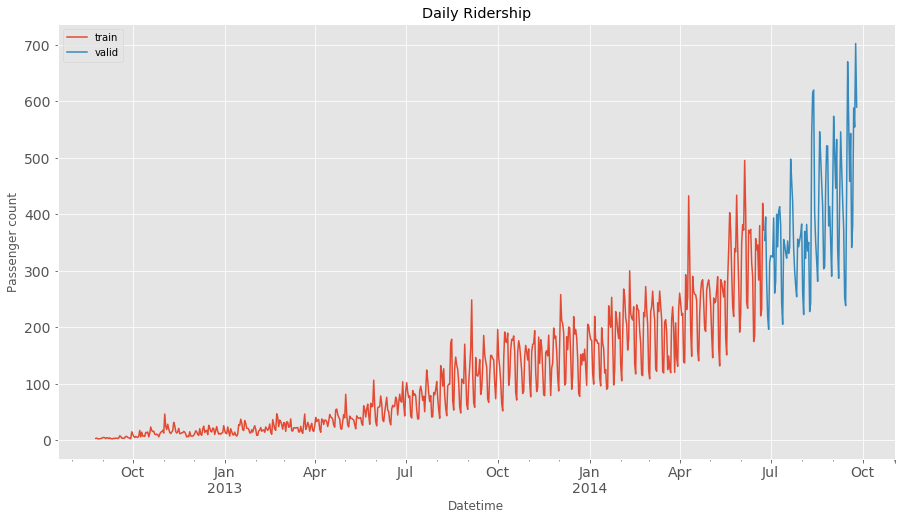

In [81]:
train_set.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
valid_set.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

### Modeling
` Naive Approch`
* In Naive forecasting method, it assume that the next expected point is equal to the last observed point. Giving a straight line as a prediction

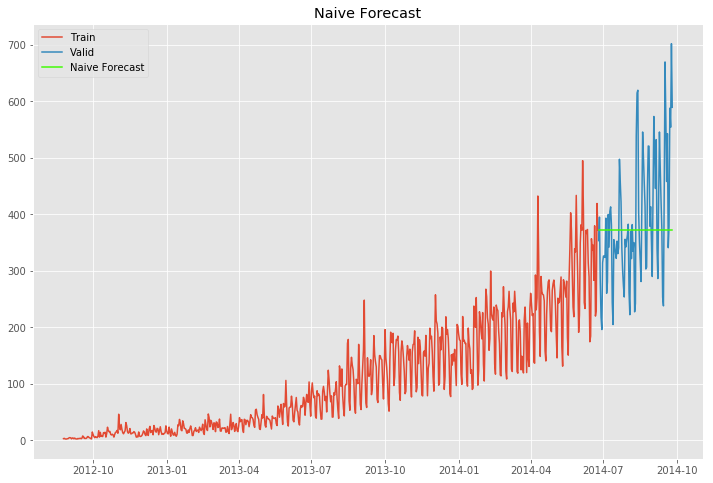

In [92]:
dd= np.asarray(train_set.Count)
y_hat = valid_set.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train_set.index, train_set['Count'], label='Train')
plt.plot(valid_set.index,valid_set['Count'], label='Valid')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast', color='#42FB06')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [94]:
# Finding the error rate using the RMSE 
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid_set.Count, y_hat.naive))
print(rms)

111.79050467496724


#### `Moving Average`
* In this technique we will take the average of the passenger counts for last few time periods only.

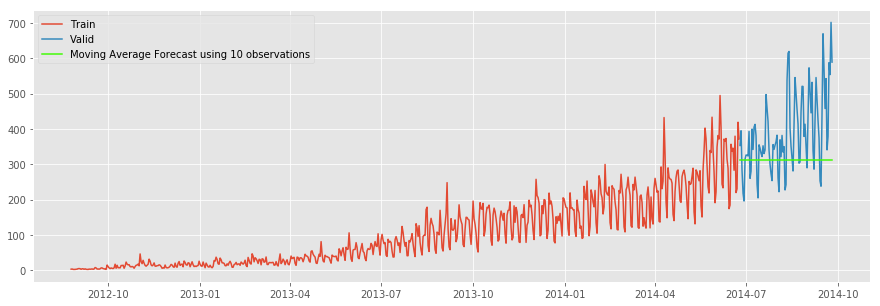

In [96]:
y_hat_avg = valid_set.copy()
y_hat_avg['moving_avg_forecast'] = train_set['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations.
plt.figure(figsize=(15,5)) 
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations',color='#42FB06')
plt.legend(loc='best')
plt.show()

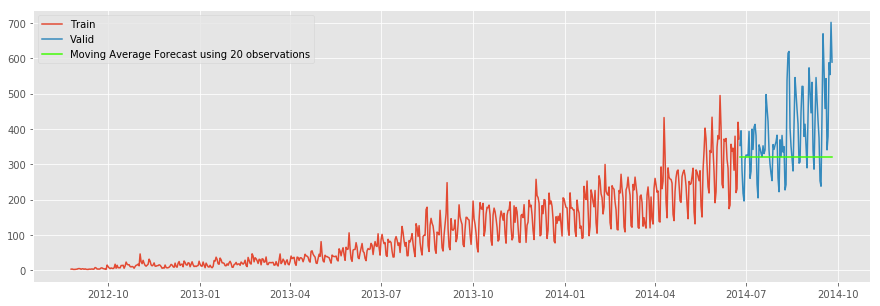

In [97]:
y_hat_avg = valid_set.copy()
y_hat_avg['moving_avg_forecast'] = train_set['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations.
plt.figure(figsize=(15,5))
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations',color='#42FB06')
plt.legend(loc='best')
plt.show()

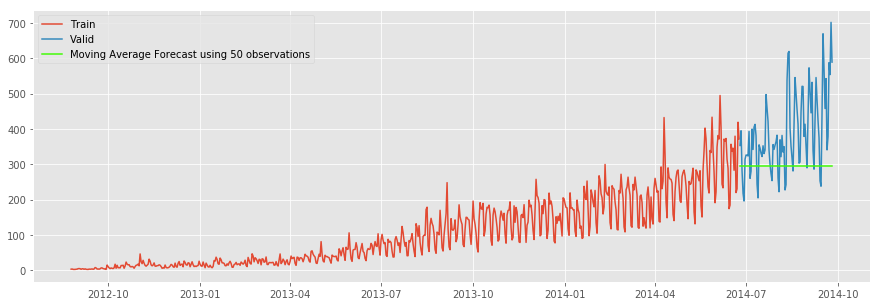

In [98]:
y_hat_avg = valid_set.copy()
y_hat_avg['moving_avg_forecast'] = train_set['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations.
plt.figure(figsize=(15,5))
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations',color='#42FB06')
plt.legend(loc='best')
plt.show()

In [99]:
rms = sqrt(mean_squared_error(valid_set.Count, y_hat_avg.moving_avg_forecast))
print(rms)

144.19175679986802


#### `Simple Exponential Smoothing`
* In this technique, we assign larger weights to more recent observations than to observations from the distant past.
* The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

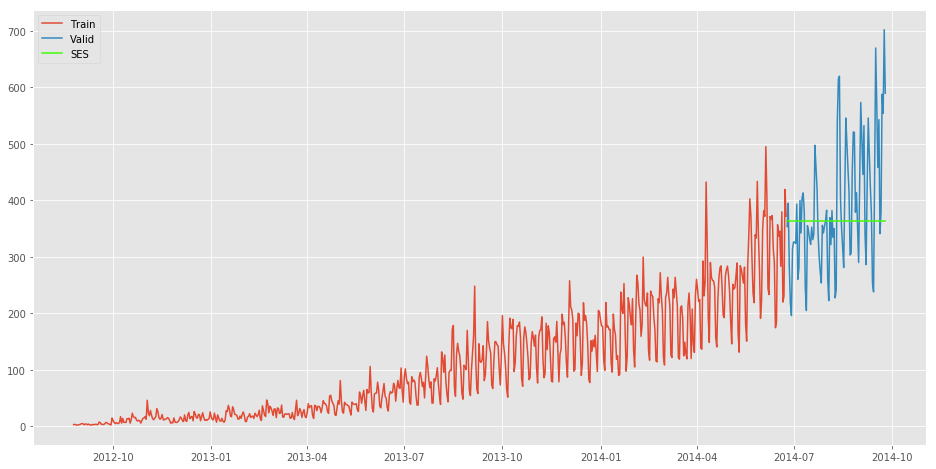

In [101]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid_set.copy()
fit2 = SimpleExpSmoothing(np.asarray(train_set['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid_set))
plt.figure(figsize=(16,8))
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES',color='#42FB06')
plt.legend(loc='best')
plt.show()

In [103]:
rms = sqrt(mean_squared_error(valid_set.Count, y_hat_avg.SES))
print(rms)

113.43708111884514


#### `Holt’s Linear Trend Model`
* Observed, which is the original time series.
* Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
* Seasonal, which tells us about the seasonality in the time series.
* Residual, which is obtained by removing any trend or seasonality in the time series.

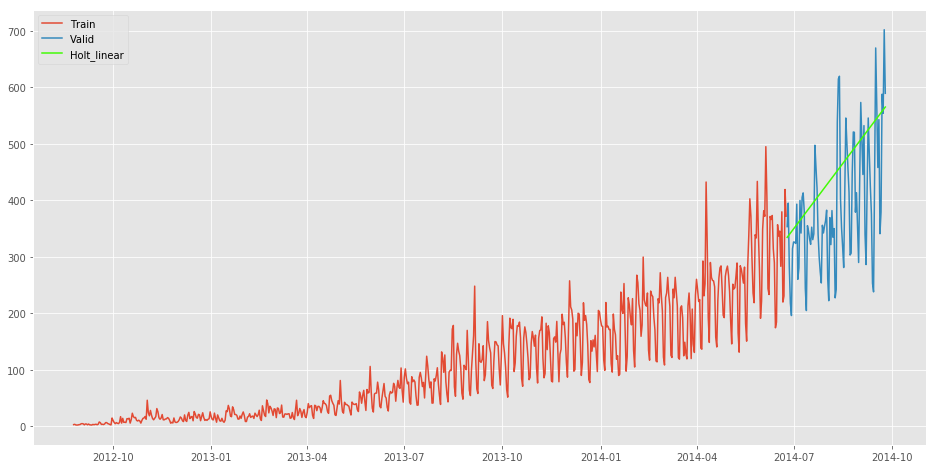

In [111]:
y_hat_avg = valid_set.copy()

fit1 = Holt(np.asarray(train_set['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid_set))

plt.figure(figsize=(16,8))
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear',color='#42FB06')
plt.legend(loc='best')
plt.show()

In [114]:
rms = sqrt(mean_squared_error(valid_set.Count, y_hat_avg.Holt_linear))
print(rms)

112.94278345314041


Predict on test set

In [118]:
predict=fit1.forecast(len(test))
# save result to new column
test['prediction']=predict

In [119]:
# Calculating the hourly ratio of count
train_original['ratio']=train_original['Count']/train_original['Count'].sum()

# Grouping the hourly ratio
temp=train_original.groupby(['Hour'])['ratio'].sum()

# Groupby to csv format
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv')

temp2=pd.read_csv("GROUPby.csv")
temp2=temp2.drop('Hour.1',1)

# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']

#### `Holt winter’s model on daily time series`
* Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

* The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

* One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

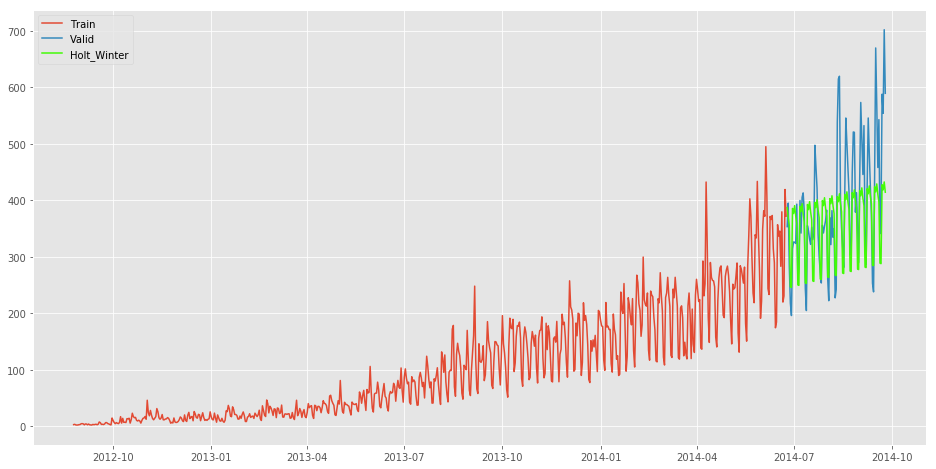

In [121]:
y_hat_avg = valid_set.copy()
fit1 = ExponentialSmoothing(np.asarray(train_set['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid_set))
plt.figure(figsize=(16,8))
plt.plot( train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter',color='#42FB06')
plt.legend(loc='best')
plt.show()

In [123]:
rms = sqrt(mean_squared_error(valid_set.Count, y_hat_avg.Holt_Winter))
print(rms)

82.37527095912128


In [125]:
predict=fit1.forecast(len(test))
test['prediction']=predict

In [126]:
# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

#### `ARIMA`
Firstly it is required to check if time series is stationary if not we need to make it stationary.

##### Stationarity Check
* We use Dickey Fuller test to check the stationarity of the series.
* The intuition behind this test is that it determines how strongly a time series is defined by a trend.
* The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
* The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [133]:
# function which we can use to calculate the results of Dickey-Fuller test.

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
   # rolmean = pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    #rolstd = pd.rolling_std(timeseries, window=24)
    
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [134]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

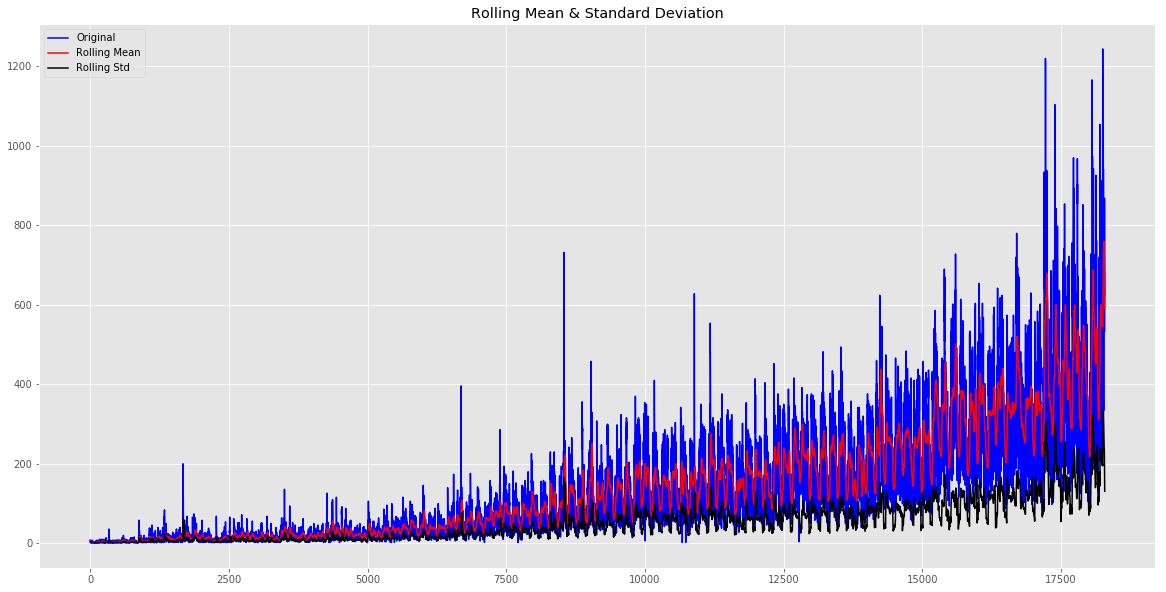

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [135]:
test_stationarity(train_original['Count'])

The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

###### Removing Trend
* A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

* We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

* We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

In [136]:
Train_log = np.log(train_set['Count'])
valid_log = np.log(valid_set['Count'])

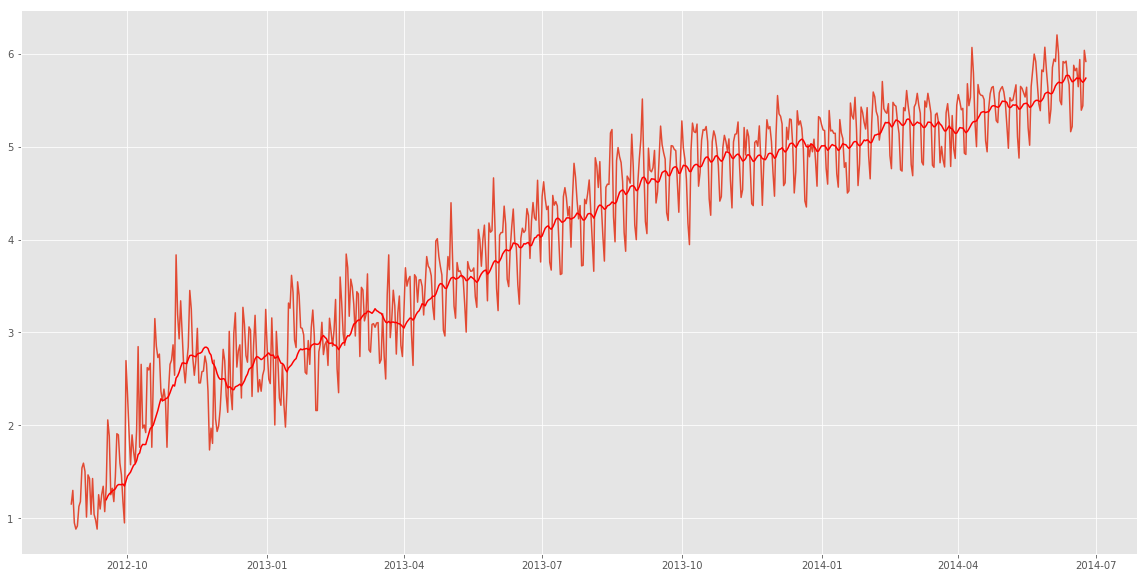

In [138]:
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')
plt.show()

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.



In [139]:
train_log_moving_avg_diff = Train_log - moving_avg

Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.



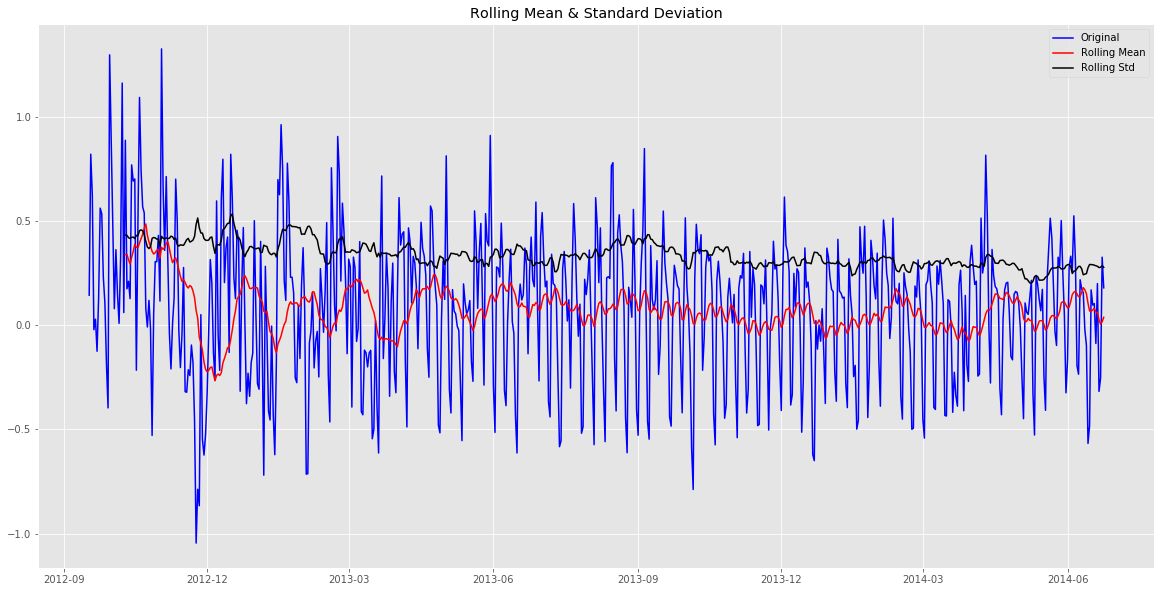

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [140]:
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

stabilize the mean of the time series which is also a requirement for a stationary time series.

* Differencing can help to make the series stable and eliminate the trend.

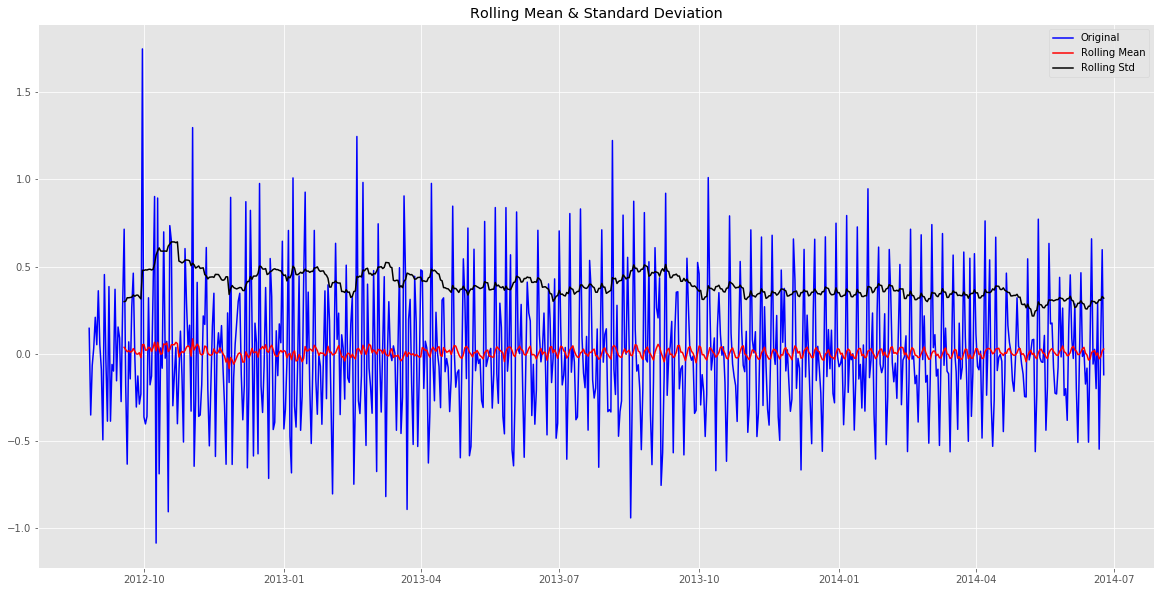

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [141]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

###### Removing Seasonality
* By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
* Seasonality is always of a fixed and known period.
* We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

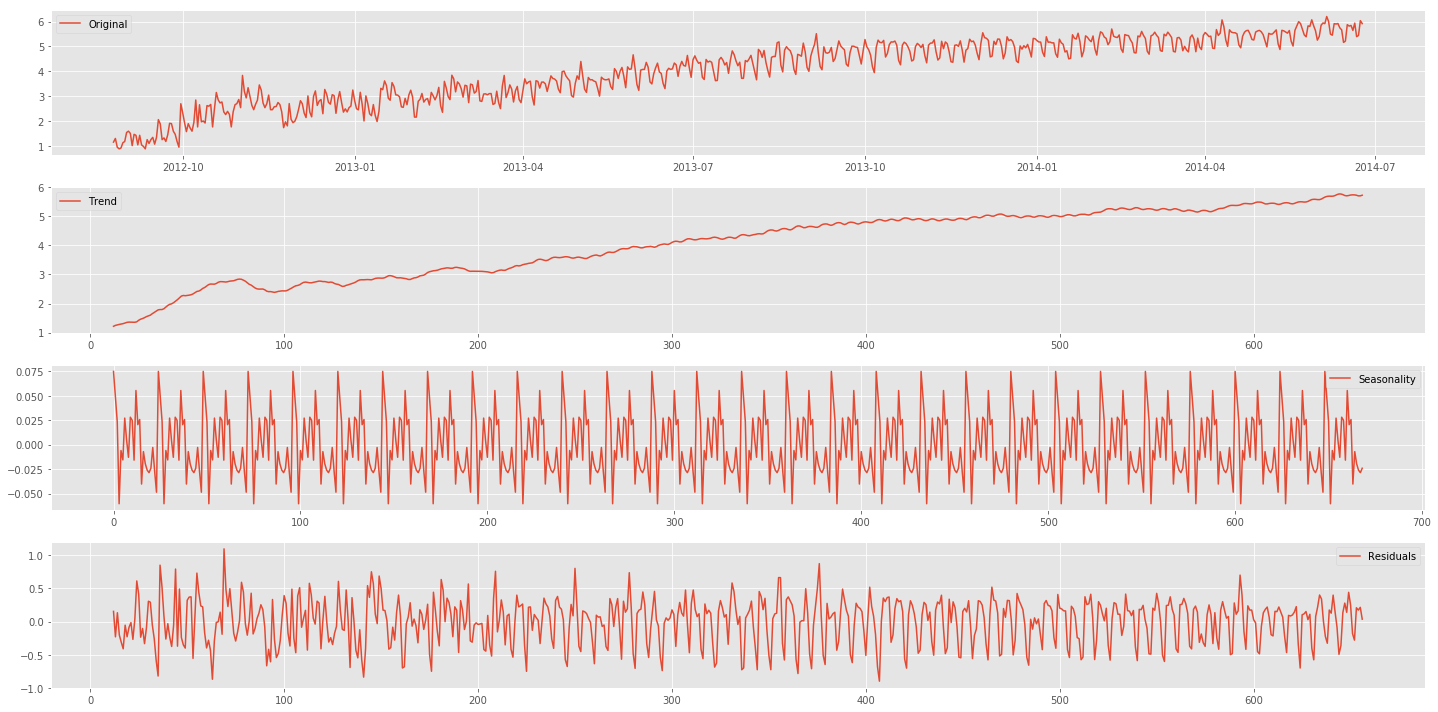

In [143]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter.

checking stationarity of residuals.



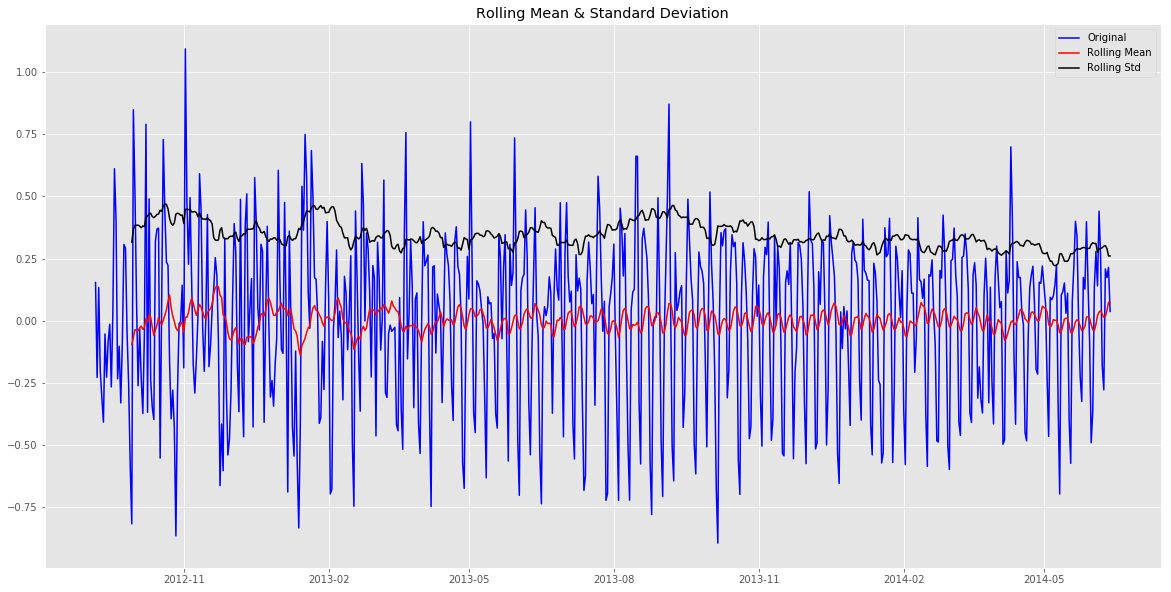

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [144]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

It can be interpreted from the results that the residuals are stationary.

Now we will forecast the time series using different models.

##### Forecasting the time series using ARIMA
First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [145]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

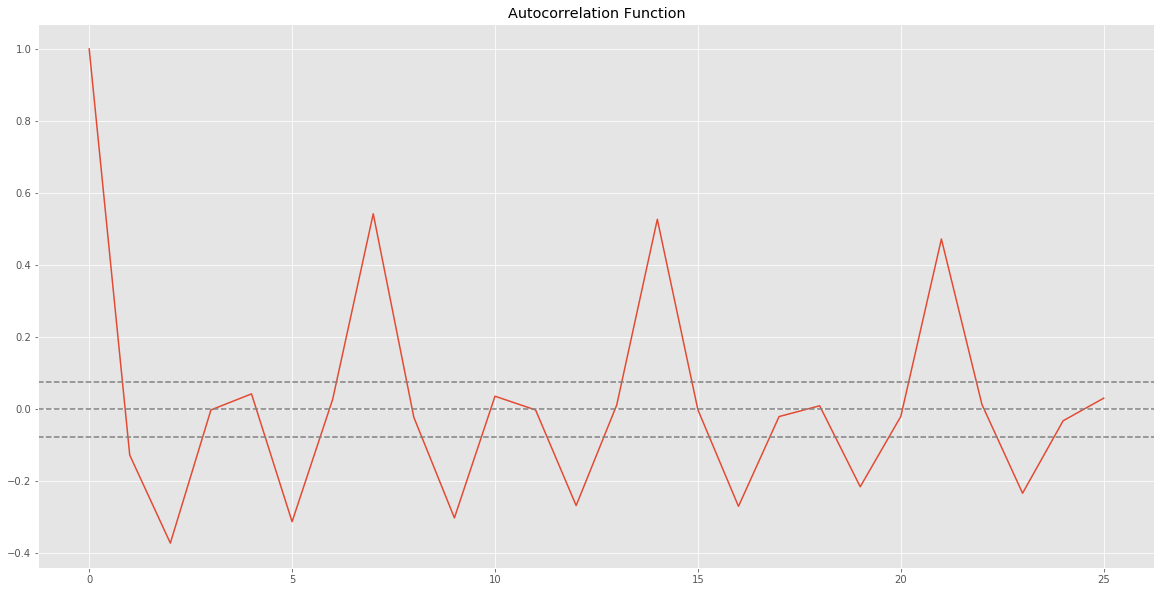

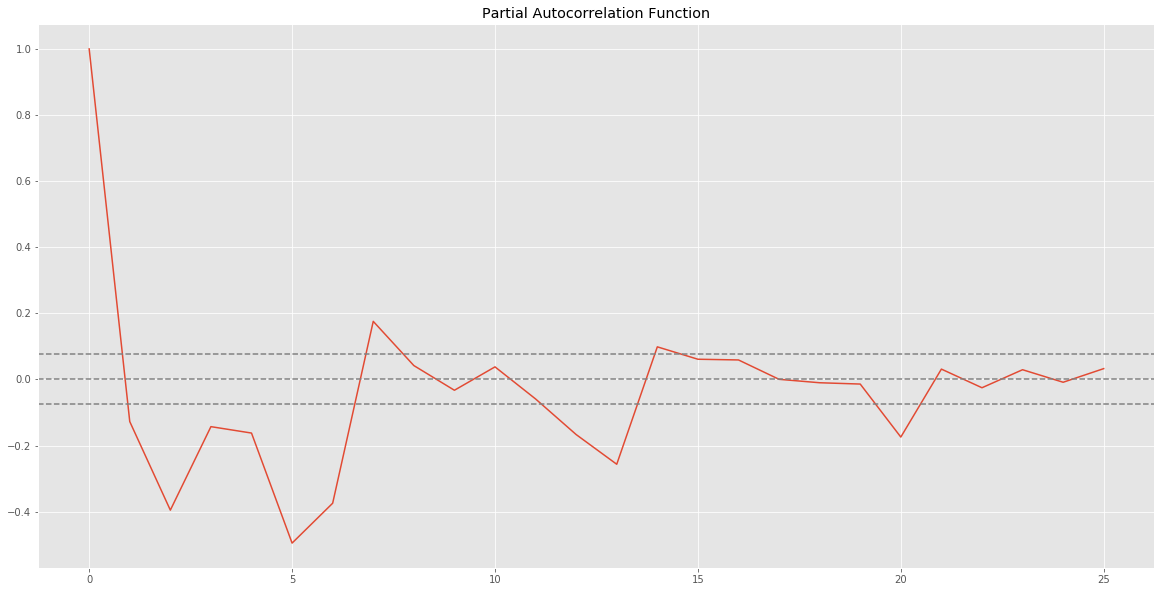

In [146]:
# ACF and PACF plot
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.
q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

##### AR model
The autoregressive model specifies that the output variable depends linearly on its own previous values

In [147]:
from statsmodels.tsa.arima_model import ARIMA

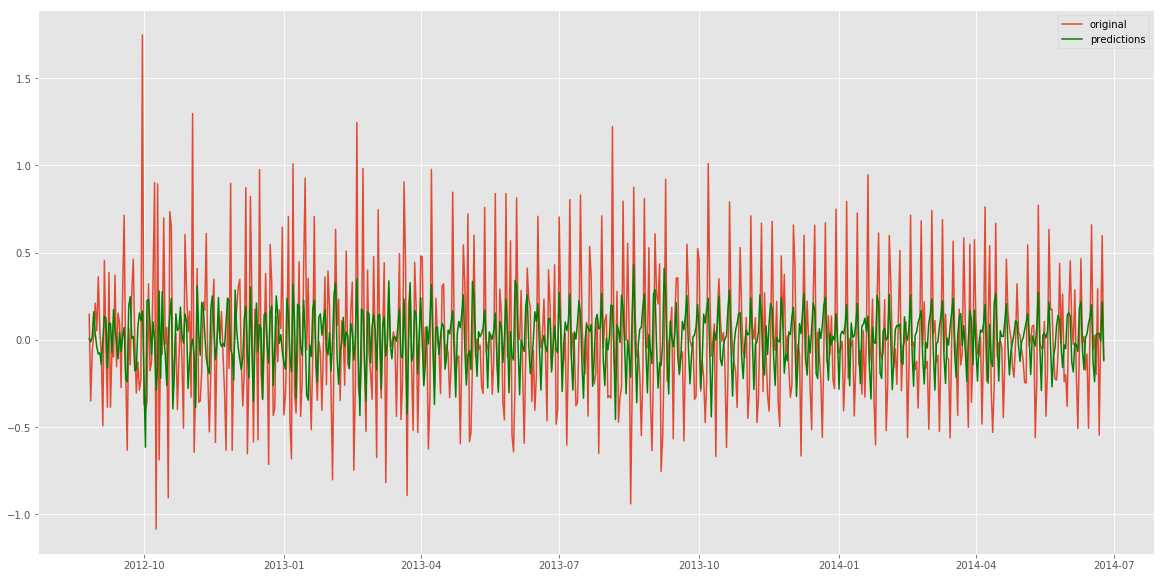

In [149]:
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_AR.fittedvalues, color='green', label='predictions')
plt.legend(loc='best')
plt.show()

In [151]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25")
AR_predict=AR_predict.cumsum().shift().fillna(0)
AR_predict1=pd.Series(np.ones(valid_set.shape[0]) * np.log(valid_set['Count'])[0], index = valid_set.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)

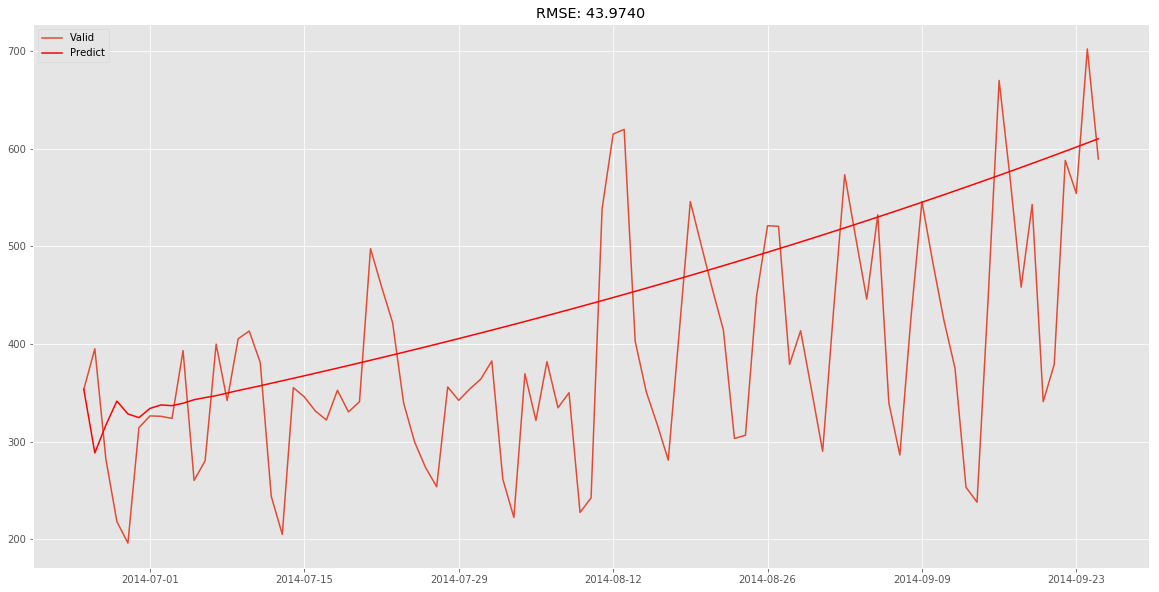

In [155]:
plt.plot(valid_set['Count'], label = "Valid")
plt.plot(AR_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid_set['Count']))/valid_set.shape[0]))
plt.show()

Here the red line shows the prediction for the validation set. Let’s build the MA model now.

#### MA model
The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

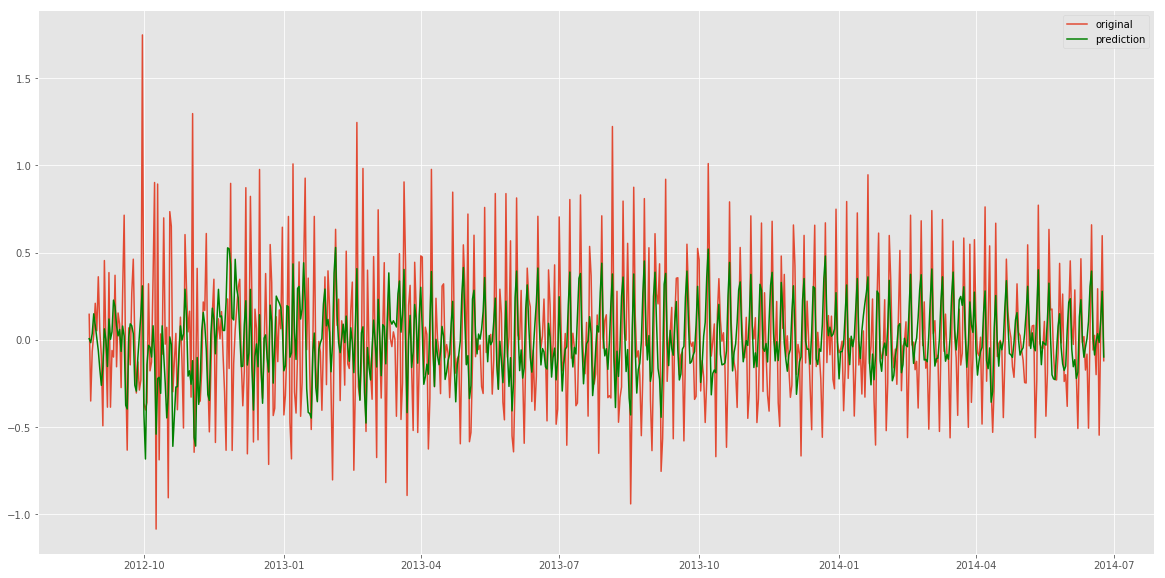

In [157]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_MA.fittedvalues, color='green', label='prediction')
plt.legend(loc='best')
plt.show()

In [159]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(valid_set.shape[0]) * np.log(valid_set['Count'])[0], index = valid_set.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)

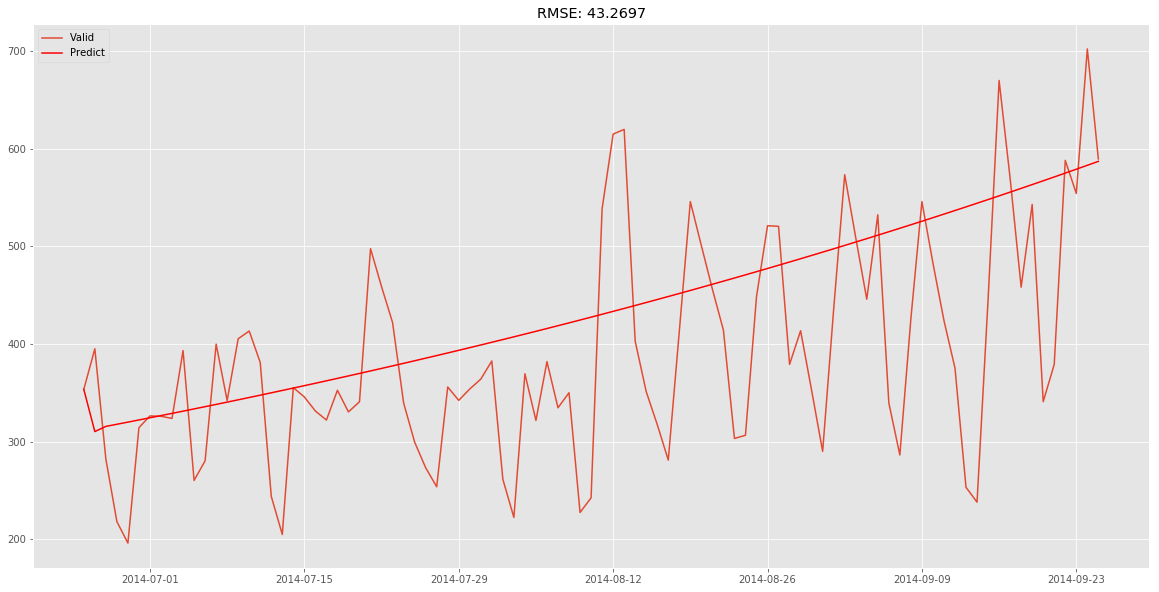

In [161]:
plt.plot(valid_set['Count'], label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid_set['Count']))/valid_set.shape[0]))
plt.show()

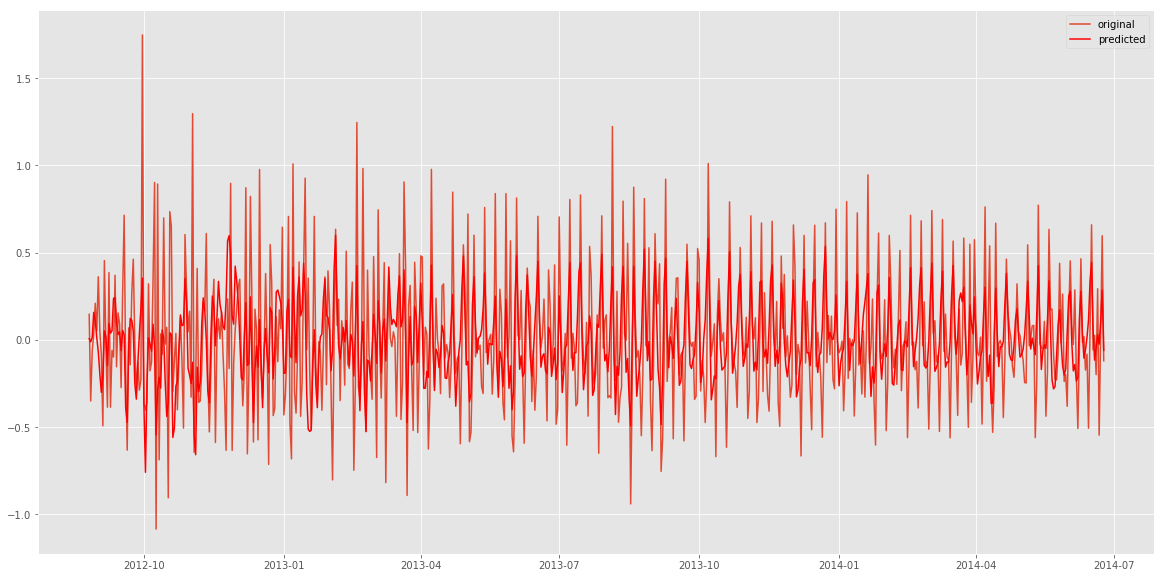

In [162]:
# Combined model
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted')
plt.legend(loc='best')
plt.show()

In [174]:
# function which can be used to change the scale of the model to the original scale.

def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'green', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [175]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'green', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [176]:
ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")

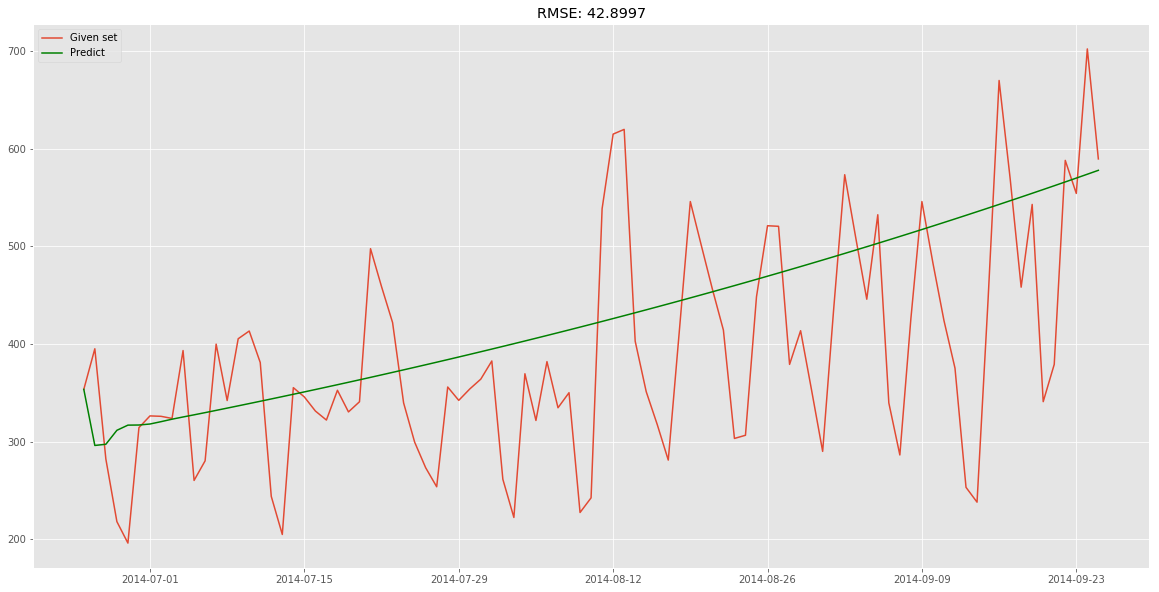

In [177]:
check_prediction_diff(ARIMA_predict_diff, valid_set)